In [32]:
import pandas as pd
import numpy as np
from sklearn.utils.extmath import randomized_svd

In [33]:
wine = pd.read_csv('/Users/victor/Documents/DataLab/2018/wine.csv')

In [34]:
wine.head()

,Year,Origin,Group,A,VA,TA,FA,pH,TPR,TPS,...,PC,ACR,ACS,ACC,CI,CI2,H,I,CA,VPC
w1,1986,Ribera,R86,12.8,1.20,6.7,5.2,3.7,2827,50.8,...,3794,386,287,181,7.81,8.95,0.720,18.4,0.489,0.21
w2,1986,Ribera,R86,12.8,0.75,6.9,6.0,3.5,1818,37.8,...,1736,144,141,69,4.88,5.55,0.755,23.6,0.480,0.56
w3,1986,Ribera,R86,12.5,1.00,7.2,6.0,3.6,1459,35.1,...,2306,225,132,78,5.52,6.35,0.456,36.8,0.598,0.38
w4,1986,Ribera,R86,11.9,0.70,7.7,6.8,3.3,2054,32.1,...,3420,204,110,84,4.64,5.15,0.675,36.4,0.420,0.29
w5,1986,Ribera,R86,12.5,0.95,7.7,6.3,3.6,2930,49.6,...,3158,214,148,75,6.99,7.87,0.672,34.2,0.450,0.36


### Standardize

In [35]:
Y_ = wine.iloc[:,:3]
X = wine.iloc[:,3:].as_matrix()
medias = X.mean(axis=0)
desv = X.std(axis=0)
dim = 7

In [36]:
X_st = (X-medias)/desv

### Groups

In [37]:
GroupNames = Y_.Group.unique()
g = len(GroupNames)
n = X.shape[0]
m = X.shape[1]
r = np.min(np.array([g - 1, m]))

In [38]:
def Factor2Binary(y,Name = None):
    if Name == None:
        Name = "C"
    ncat = len(y.unique())
    n = len(y)
    Z = pd.DataFrame(0, index=np.arange(len(y)), columns=y.unique())
    for col in Z.columns:
        for i in range (0,n):
            if y[i] == col:
                Z[col].iloc[i] = 1
    return Z

In [39]:
def matrixsqrt(M,dim,tol=np.finfo(float).eps,inv=True):
    U, Sigma, VT = randomized_svd(M, n_components=dim, n_iter=5, random_state=None)
    nz = Sigma > tol
    if inv==True:
        S12 = U.dot(np.diag(1/np.sqrt(Sigma[nz]))).dot(VT[nz,:])
    else:
        S12 = U.dot(np.diag(np.sqrt(Sigma[nz]))).dot(VT[nz,:])
    return S12

In [83]:
Z = Factor2Binary(Y_.Group)
ng = Z.sum(axis=0)
S11 = np.transpose(Z).dot(Z)
Xb = np.linalg.inv(S11).dot(np.transpose(Z)).dot(X_st)
B = (Xb.T).dot(S11).dot(Xb)
S = (X_st.T).dot(X_st) - B
Y = np.power(S11,0.5).dot(Xb).dot(matrixsqrt(S,dim,inv=True))

U, Sigma, VT = randomized_svd(Y, n_components=dim, n_iter=5, random_state=None)
H = matrixsqrt(S,dim,inv=False).dot(np.transpose(VT[0:r,:]))
B = matrixsqrt(S,dim,inv=True).dot(np.transpose(VT[0:r,:]))

J = Xb.dot(B)
V = X_st.dot(B)

In [89]:
sct = np.diag((V.T).dot(V))
sce = np.diag((J.T).dot(S11).dot(J))
scr = sct -sce
fs = (sce/(g - 1))/(scr/(n - g))
vprop = Sigma[:r]
iner = (np.power(vprop,2)/(np.power(vprop,2).sum()))*100

In [91]:
%pylab inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


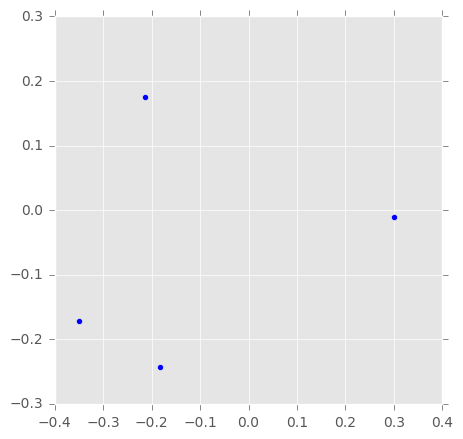

In [94]:
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

ax1.scatter(J[:,0],J[:,1])